In [1]:
import trackpy as tp
import cv2
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import imageio

In [2]:
import joblib
joblib.__version__

'1.3.0.dev0'

In [3]:
import sys
sys.executable

'/media/baptiste/Windows/Users/LUMIN10/Documents/code/envs/mint/bin/python'

In [4]:
inpath = r'/media/baptiste/Windows/Users/LUMIN10/Documents/Données/video_benchmark_min/Exp1_20190205_06_kif5a_nKTP/HET/larve3/oeil_droit/190205_nanoKTP_kif5a.lif - Series006.tif'
frames = imageio.volread(inpath)
frames.shape

(1765, 350, 512)

In [6]:
def tophat(separation,frame):

    kernelC = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(separation,separation))
    processed_frame = cv2.morphologyEx(frame,cv2.MORPH_TOPHAT,kernelC)

    return processed_frame

In [10]:
%%timeit
processed_frames = frames.astype('float64')

3.26 s ± 1.44 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%%timeit
processed_frames_no_copy = frames.astype('float64',copy=False)

1.35 s ± 229 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
processed_frames = frames.astype('float64')

In [13]:
%%timeit
for i in range(len(frames)):
    processed_frames[i] = tophat(12,processed_frames[i])
processed_frames.shape

22.7 s ± 691 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
for i in range(len(frames)):
    processed_frames[i] = tophat(12,processed_frames[i])
processed_frames.shape

(1765, 350, 512)

In [14]:
%%timeit
processed_frames_list = Parallel(n_jobs=12)(delayed(tophat)(12,frame) for frame in processed_frames)

for i, frame in enumerate(processed_frames_list):
    processed_frames[i] = frame

processed_frames.shape

9.29 s ± 587 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%%timeit
processed_frames_gen = Parallel(n_jobs=12,return_generator=True)(delayed(tophat)(12,frame) for frame in processed_frames)

for i in range(len(processed_frames)):
    processed_frames[i] = next(processed_frames_gen)
processed_frames.shape

9.21 s ± 194 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
# %%time
# par = Parallel(n_jobs=12, return_generator=True)
# processed_frames_gen = par(delayed(tophat)(12,frame) for frame in processed_frames)
processed_frames_gen = Parallel(n_jobs=12,return_generator=True)(delayed(tophat)(12,frame) for frame in processed_frames)

In [31]:
%%time
for i in range(len(processed_frames)):
    processed_frames[i] = next(processed_frames_gen)

processed_frames.shape

CPU times: user 5.84 s, sys: 2.35 s, total: 8.18 s
Wall time: 7.56 s


(1765, 350, 512)

In [33]:
%%time
for i, frame in zip(range(len(processed_frames)), processed_frames_gen):
    processed_frames[i] = frame

processed_frames.shape

CPU times: user 4.27 s, sys: 1.67 s, total: 5.94 s
Wall time: 6.02 s


(1765, 350, 512)

In [ ]:
for x, y in zip([1,2,3],[4,5,6]):
    print(x)
    print(y)

In [ ]:
def gen():
    for i in range(456):
        yield i,i+1,i+2

next(gen())

In [ ]:
for a, b, c in gen():
    print(a,b,c)

## MSD

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import trackpy as tp

In [57]:
inpath = r'/media/baptiste/Windows/Users/LUMIN10/Documents/Données/video_benchmark_min Results - 20230526_142340/video_benchmark_min/Exp1_20190205_06_kif5a_nKTP/HET/larve3/oeil_droit/190205_nanoKTP_kif5a.lif - Series006.tif/190205_nanoKTP_kif5a.lif - Series006.tif.csv'

df = pd.read_csv(inpath,sep='\t')
df.head()

,Unnamed: 0,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,max_msd
0,52,209.351055,399.286526,2464.0,2.180846,0.132260,234.0,2464.0,0.0,0,1,0.201725
1,121,208.700919,399.208020,2394.0,2.133004,0.126221,234.0,2394.0,0.0,1,1,0.201725
2,189,208.076960,399.829245,2079.0,2.113085,0.100161,186.0,2079.0,0.0,2,1,0.201725
3,262,208.103043,400.189002,1873.0,2.119117,0.060523,160.0,1873.0,0.0,3,1,0.201725
4,329,208.554339,399.867734,2374.0,2.210300,0.055561,181.0,2374.0,0.0,4,1,0.201725


In [58]:
df = df.drop(['max_msd'],axis=1)
df.head()

,Unnamed: 0,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,52,209.351055,399.286526,2464.0,2.180846,0.132260,234.0,2464.0,0.0,0,1
1,121,208.700919,399.208020,2394.0,2.133004,0.126221,234.0,2394.0,0.0,1,1
2,189,208.076960,399.829245,2079.0,2.113085,0.100161,186.0,2079.0,0.0,2,1
3,262,208.103043,400.189002,1873.0,2.119117,0.060523,160.0,1873.0,0.0,3,1
4,329,208.554339,399.867734,2374.0,2.210300,0.055561,181.0,2374.0,0.0,4,1


In [ ]:
def MSD_base(tracks,px,dt):
    df = pd.DataFrame()
    for item in set(tracks.particle):
        subtracks = tracks[tracks.particle==item].copy()
        if len(subtracks) > 1:
            df2 = tp.motion.msd(subtracks,px,(1/dt),max_lagtime=len(subtracks))
            max_msd = [df2.msd.max()]*len(subtracks)    
            max_msd = pd.DataFrame(max_msd,columns=['max_msd'])
            # df = df.reset_index(drop=True)
            subtracks['max_msd'] = max_msd.values
            df = pd.concat((df,subtracks))

    return df

In [60]:
def MSD_traj(subtracks):
    
    if len(subtracks) > 1:
            df2 = tp.motion.msd(subtracks,0.173,(1/0.05),max_lagtime=len(subtracks))
            max_msd = [df2.msd.max()]*len(subtracks)    
            max_msd = pd.DataFrame(max_msd,columns=['max_msd'])
            # df = df.reset_index(drop=True)
            subtracks['max_msd'] = max_msd.values
    return subtracks

In [62]:
df1 = pd.DataFrame()
for item in set(df.particle):
    subtracks = df[df.particle==item].copy()
    df1 = pd.concat((df1,MSD_traj(subtracks)))


df1.head()

,Unnamed: 0,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,max_msd
0,52,209.351055,399.286526,2464.0,2.180846,0.132260,234.0,2464.0,0.0,0,1,0.201725
1,121,208.700919,399.208020,2394.0,2.133004,0.126221,234.0,2394.0,0.0,1,1,0.201725
2,189,208.076960,399.829245,2079.0,2.113085,0.100161,186.0,2079.0,0.0,2,1,0.201725
3,262,208.103043,400.189002,1873.0,2.119117,0.060523,160.0,1873.0,0.0,3,1,0.201725
4,329,208.554339,399.867734,2374.0,2.210300,0.055561,181.0,2374.0,0.0,4,1,0.201725


In [ ]:
mm = Parallel(n_jobs=12)(delayed(MSD_traj)(df[df.particle==traj]) for traj in set(df.particle))
dff = pd.concat(mm)
dff.head()

In [ ]:
len(mm)
type(mm[0])

In [35]:
import multiprocessing

multiprocessing.cpu_count()

12

# Test Tophat

In [5]:
import imageio
import pandas as pd
import numpy as np
import cv2
import scipy
import matplotlib.pyplot as plt

In [7]:
def tophat(separation,frame):

    kernelC = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(separation,separation))
    processed_frame = cv2.morphologyEx(frame,cv2.MORPH_TOPHAT,kernelC)

    return processed_frame

In [2]:
inpath = r'/media/baptiste/Windows/Users/LUMIN10/Documents/Données/video_benchmark_min/Exp1_20190205_06_kif5a_nKTP/HET/larve3/oeil_droit/190205_nanoKTP_kif5a.lif - Series006.tif'
frames = imageio.volread(inpath)
frames.shape

(1765, 350, 512)

2.0152678571428573

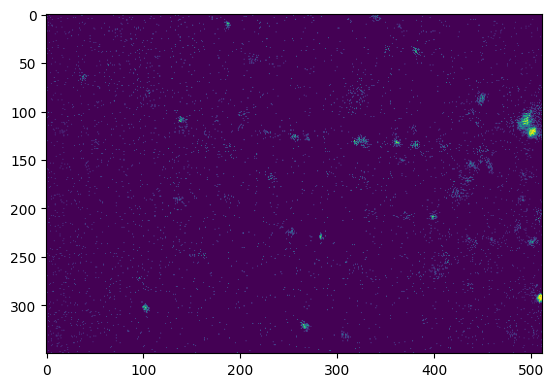

In [10]:
plt.imshow(frames[0])
np.mean(frames[0])

In [ ]:
for i in range(len(frames)):
    processed_frames[i] = tophat(12,processed_frames[i])

In [8]:
processed_frame = tophat(12, frames[0])

2.0152678571428573

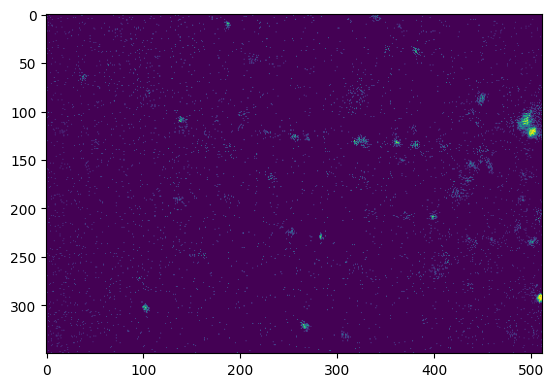

In [11]:
plt.imshow(processed_frame)
np.mean(processed_frame)

### CV2

Mean before = mean after 

No effect ?

### SciPy

In [15]:
kernelC = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(12,12))
kernelC

array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0]], dtype=uint8)

In [16]:
pf_scipy = scipy.ndimage.white_tophat(frames[0], footprint=kernelC)

2.0152678571428573

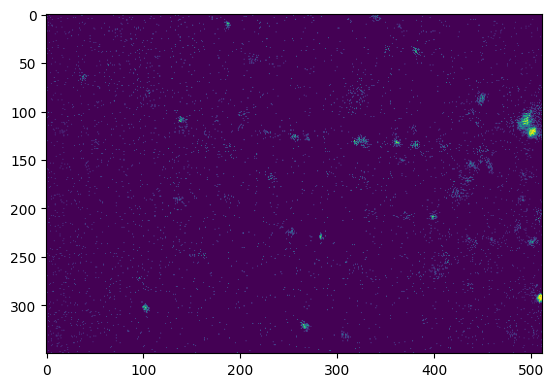

In [17]:
plt.imshow(pf_scipy)
np.mean(pf_scipy)

Idem

### SKIMAGE

In [18]:
import skimage
pf_skimage = skimage.morphology.white_tophat(frames[0], footprint=kernelC)

2.0152678571428573

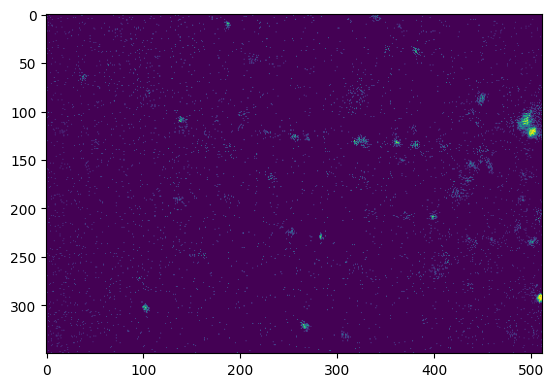

In [19]:
plt.imshow(pf_skimage)
np.mean(pf_skimage)

## Test sur images TIRF

In [20]:
data = imageio.volread(r'/media/baptiste/Windows/Users/LUMIN10/Documents/stack.tif')
data.shape

(100, 1002, 1004)

971.9199479527002

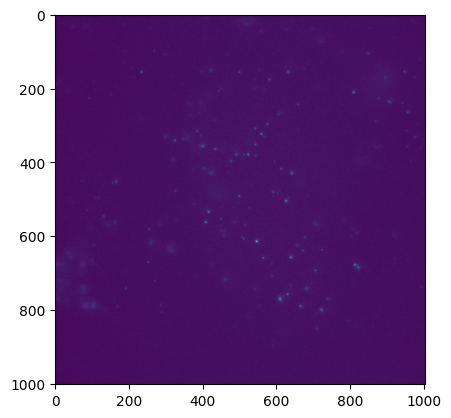

In [24]:
plt.imshow(data[0])
np.mean(data[0])

### CV2

In [35]:
%%timeit
df_cv2 = tophat(12, data[0])

7.56 ms ± 118 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


325.8738479216865

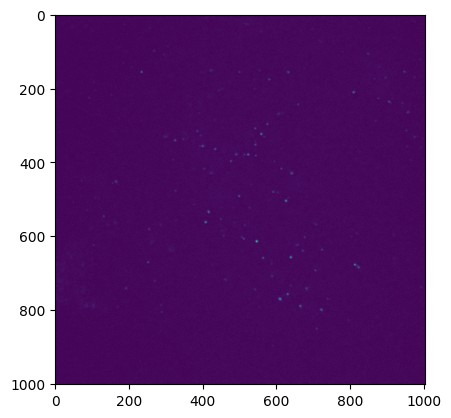

In [22]:
plt.imshow(df_cv2)
np.mean(df_cv2)

### SciPy

In [33]:
%%timeit
df_scipy = scipy.ndimage.white_tophat(data[0], footprint=kernelC)

325 ms ± 12.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


325.6460763731501

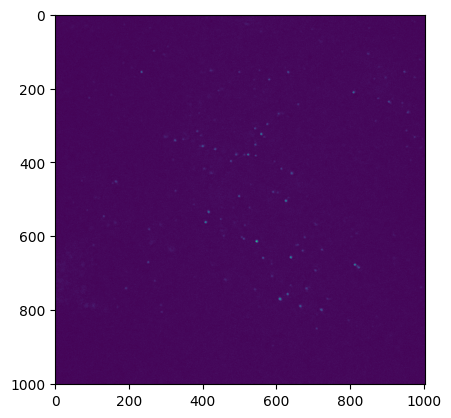

In [28]:
plt.imshow(df_scipy)
np.mean(df_scipy)

### SKIMAGE

In [30]:
import skimage

In [34]:
%%timeit
df_skimage = skimage.morphology.white_tophat(data[0], footprint=kernelC)

325 ms ± 18.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


325.6460763731501

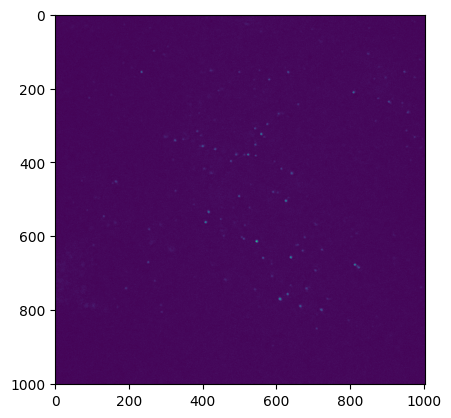

In [31]:
plt.imshow(df_skimage)
np.mean(df_skimage)

SciPy et SKIMAGE numériquement équivalents

CV2 proche à deux dixièmes près

CV2 : 7.48 ms pour 1 frame de 1000 x 1000

SciPy : 325 ms pour 1 frame de 1000 x 1000

SKIMAGE : 325 ms pour 1 frame de 1000 x 1000

SciPy et SKIMAGE semblent identiques

CV2 ~4 fois plus rapide

### Test de vitesse sur 100 frames

In [35]:
import trackpy as tp
import cv2
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import imageio
import scipy
import skimage

In [36]:
frames = imageio.volread(r'/media/baptiste/Windows/Users/LUMIN10/Documents/stack.tif')
frames.shape

(100, 1002, 1004)

In [40]:
processed_frames = frames.astype('float64')

In [39]:
def tophat(separation,frame):

    kernelC = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(separation,separation))
    processed_frame = cv2.morphologyEx(frame,cv2.MORPH_TOPHAT,kernelC)

    return processed_frame

Méthode classique

In [41]:
for i in range(len(frames)):
    processed_frames[i] = tophat(12,processed_frames[i])
print(processed_frames.shape)
print(np.mean(processed_frames))
print(np.median(processed_frames))

(100, 1002, 1004)
319.74757244475194
295.0


Joblib sans générateur

In [42]:
processed_frames_p_no_gen = frames.astype('float64')

In [43]:
processed_frames_list = Parallel(n_jobs=12)(delayed(tophat)(12,frame) for frame in processed_frames_p_no_gen)

for i, frame in enumerate(processed_frames_list):
    processed_frames_p_no_gen[i] = frame

print(processed_frames_p_no_gen.shape)
print(np.mean(processed_frames_p_no_gen))
print(np.median(processed_frames_p_no_gen))

(100, 1002, 1004)
319.74757244475194
295.0


Joblib, générateur, next

In [49]:
processed_frames_p_next = frames.astype('float64')

In [50]:
processed_frames_gen = Parallel(n_jobs=12,return_generator=True)(delayed(tophat)(12,frame) for frame in processed_frames_p_next)

In [51]:
for i in range(len(processed_frames_p_next)):
    processed_frames_p_next[i] = next(processed_frames_gen)

print(processed_frames_p_next.shape)
print(np.mean(processed_frames_p_next))
print(np.median(processed_frames_p_next))

(100, 1002, 1004)
319.74757244475194
295.0


Joblib, générateur, zip

In [52]:
processed_frames_p_zip = frames.astype('float64')

In [53]:
processed_frames_gen = Parallel(n_jobs=12,return_generator=True)(delayed(tophat)(12,frame) for frame in processed_frames_p_zip)

In [54]:
for i, frame in zip(range(len(processed_frames)), processed_frames_gen):
    processed_frames_p_zip[i] = frame

print(processed_frames_p_zip.shape)
print(np.mean(processed_frames_p_zip))
print(np.median(processed_frames_p_zip))

(100, 1002, 1004)
319.74757244475194
295.0


Versions numériquement équivalentes

CV2

In [9]:
%%timeit
for i in range(len(frames)):
    processed_frames[i] = tophat(12,processed_frames[i])

7.82 s ± 31.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
kernelC = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(12,12))
kernelC

array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0]], dtype=uint8)

SciPy

In [16]:
%%timeit
for i in range(len(frames)):
    processed_frames[i] = scipy.ndimage.white_tophat(frames[i], footprint=kernelC)

34.9 s ± 3.57 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Parallelization minimization

In [1]:
from scipy.signal import savgol_filter
from traj_calc import *

log_analysis = {
    'r_poly':0,
    'r_speed':0,
}

list_r_conf = []

parameters = {
# Data Extraction
'r_conf_cut' : 0.74,
'px' : 0.111, # in µm
'dt' : 0.05, # in s
'min_thr_prec' : 50, # in nm
'sliding_window':3,
'sigma':129,
'len_cutoff':30, # Number of points
'threshold_poly3':1.4, # Deviation from third-degree polynom
}   
settings = {
# Data Extraction
'polynomial_fit':False,
'minimization':False,
'antero_retro':False,
'theta':False,
'conf_list':True,
}


In [2]:
def inst_velocity(x,y,dt):
    """Calculates instantaneous velocity.

    :param x: Array of x coordinates
    :type x: NumPy array
    :param y: Array of y coordinates
    :type y: NumPy array
    :param dt: Sampling period in seconds.
    :type dt: float
    :return: Array of point by point instantaneous velocity
    :rtype: NumPy array
    """    

    size = len(x)
    v_inst = np.zeros(size)
    v_inst[0] = (np.sqrt((x[1]-x[0])**2+(y[1]-y[0])**2))/dt # Instantaneous speed of the first point calculated from the first segment
    v_inst[size-1] = (np.sqrt((x[size-1]-x[size-2])**2+(y[size-1]-y[size-2])**2))/dt # Instantaneous speed of the last point calculated from the last segment

    for u in range(size-2):
        u = u+1
        v_inst[u] = (np.sqrt((x[u+1]-x[u-1])**2+(y[u+1]-y[u-1])**2))/(2*dt)

    return v_inst

def confinement(x,y,sw):
    """Calculates point by point confinement ratio

    :param x: Array of x coordinates
    :type x: NumPy array
    :param y: Array of y coordinates
    :type y: NumPy array
    :param sw: Confinement ratio sliding window in number of points.
    :type sw: int
    :return: List of point by point confinement ratio
    :rtype: list
    """    

    r_conf = []
    size=len(x)

    if (size>=2*sw+1):
        for i in range(sw): # Extrapolate the confinement ratio at the beginning of the trajectory
            d_net = np.sqrt((x[sw*2]-x[0])**2+(y[sw*2]-y[0])**2)
            d_total = 0
            for u in range(2*sw):
                d_total = d_total + np.sqrt((x[u+1]-x[u])**2+(y[u+1]-y[u])**2)
            r_conf.append((d_net/d_total))

        for i in range (sw,size-sw):
            if (i == size-sw-1): # Extrapolate a number of points equal to the sliding window at the end
                d_total = 0
                d_net = np.sqrt((x[i+sw]-x[i-sw])**2+(y[i+sw]-y[i-sw])**2)
                for j in range (2*sw):
                    d_total = d_total + np.sqrt((x[(i-sw)+j+1]-x[(i-sw)+j])**2+(y[(i-sw)+j+1]-y[(i-sw)+j])**2)
                if (d_total!=0):
                    for p in range(sw+1):
                        r_conf.append((d_net/d_total))
                else:
                    for p in range(sw+1):
                        r_conf.append(0)
            else:

                d_total = 0
                d_net = np.sqrt((x[i+sw]-x[i-sw])**2+(y[i+sw]-y[i-sw])**2)
                for j in range (2*sw):
                    d_total = d_total + np.sqrt((x[(i-sw)+j+1]-x[(i-sw)+j])**2+(y[(i-sw)+j+1]-y[(i-sw)+j])**2)
                if (d_total!=0):
                        r_conf.append((d_net/d_total))
                else:
                        r_conf.append(0)
    else:
        pass
    return r_conf


In [ ]:
dt = parameters['dt']
sw = parameters['sliding_window']
conf_threshold = parameters['min_thr_prec']*1e-3/(dt*(sw-1)) # in µm/s, threshold defined by a minimal velocity of 10nm/dt (or 0.2µm/s)
f_phase_parameters = pd.DataFrame()

for trajectory in set(data.particle):

    subdata = data[data.particle==trajectory]
    subdata = subdata.reset_index(drop = True)

    if settings['polynomial_fit']: # Fit trajectories to third-degree polynom, and discard trajectories that deviate too much
        if polynomial_fit(subdata,parameters['len_cutoff'],parameters['threshold_poly3']) == True:
            pass
        else:
            log_analysis['r_poly'] += 1
            continue

    if settings['minimization']: # Experimental trajectory denoising
        subdata = minimization(subdata,parameters['px'],parameters['sigma']) # Defined noise level for every trajectories
        #subdata = point_minimization(subdata,parameters['px']) # Point-by-point calculation of noise level based on signal intensity

    x = subdata.x
    x = x.dropna()
    
    y = subdata.y
    y = y.dropna()
    
    x = x.reset_index(drop = True)
    y = y.reset_index(drop = True)

    size = len(x)
    
    r_conf = confinement(x,y,sw) # Separate trajectory into phases

    if settings['conf_list']:
        list_r_conf.append(r_conf)

    # Switch from pixels to µm   
    x = x*parameters['px']
    x = x.dropna()
    y = y*parameters['px']
    y = y.dropna()

    v_inst = inst_velocity(x,y,dt) # Get instantaneous velocity for each point

    phase = np.zeros(size)

    # Categorize each phase as either a GO or STOP phase
    if (size>=2*sw+1):
        for i in range(len(r_conf)):
            if (r_conf[i]>parameters['r_conf_cut']):
                    phase[i] = 2 # GO phase

    else:
        for i in range(sw,(size-sw)): # STOP phase refinment
            vel_list = []
            for j in range((i+(-1*(sw//2))),(i+(sw//2))):
                vel = (np.sqrt((x[j+1]-x[j])**2+(y[j+1]-y[j])**2))/dt
                vel_list.append(vel)

            if (phase[i]==2) & (np.mean(vel_list)<conf_threshold):
                phase[i] = 0
    
    subdata['Vinst'] = v_inst
    subdata = subdata.reset_index(drop = True)
    
    diff = []
    cut = []

    for i in range(size-1):
        diff.append(phase[i+1]-phase[i])

    for j in range(size-1):
        if (diff[j]==1 or diff[j]==-1 or diff[j]==2 or diff[j]==-2):
            cut.append(j+1)

    cut.append(len(subdata))

    min_x = x[cut[0]-1]
    max_x = x[(cut[len(cut)-1])-1]

    min_y = y[cut[0]-1]
    max_y = y[(cut[len(cut)-1])-1]

    for phase_number in range(len(cut)-1): # Per phase processing. '-1' : First and last phases are deleted
        start = cut[phase_number]
        stop = cut[phase_number+1]
        sub_phase = subdata.loc[start:stop-1]
        intensity = sub_phase.mass

        sub_v_inst = sub_phase.Vinst 
        phase_length = len(sub_phase)
        phase_duration = phase_length*dt

        variance = (np.std(intensity))**2
        mean_intensity = np.mean(intensity)

        if (phase_length==1):
            variance = 0

        if settings['theta']:
            # Calculate theta angle of each particle based on variation of intensity
            # Specific to nanoKTP or similarly behaving nanoparticles

            thetalist = []
            savgol = savgol_filter(intensity,window_length=9,polyorder=3,mode="nearest")

            for n in savgol:
                thetalist.append(np.arcsin(np.sqrt((n-np.min(savgol))/(np.max(savgol)-np.min(savgol))))\
                        if np.max(savgol) != np.min(savgol) else np.nan) # Prevent division by zero

            theta = np.array(thetalist)*180/np.pi
            theta_std = np.std(theta)

        curvilign_velocity = np.abs(np.mean(sub_v_inst))
        vectorial_velocity = np.abs((np.sqrt((x[stop-1]-x[start])**2+(y[stop-1]-y[start])**2))/(dt*phase_length))
        
        if settings['antero_retro']:
            # Check wether trajectory belongs to the right or left eye
            if slide == "oeil_droit":
                sign = 1
            else:
                sign = -1

            # Change the sign of the velocity accordingly
            if ((x[stop-1]-x[start])>0):
                curvilign_velocity = -sign * curvilign_velocity
                vectorial_velocity = -sign * vectorial_velocity
            else:
                curvilign_velocity = sign * curvilign_velocity
                vectorial_velocity = sign * vectorial_velocity
        
        if (phase[start]==0):
            phase_sign = 0
        if (phase[start]==2):
            phase_sign = 2

        run_length = curvilign_velocity*phase_duration
        curv_length = curvilign_velocity*dt

        data_dict = {'trajectory': trajectory, 
                    'phase':phase_sign,
                    'phase_number':phase_number,
                    'phase_length':phase_length,
                    'vectorial_velocity':vectorial_velocity,
                    'curvilign_velocity':curvilign_velocity,
                    'phase_duration':phase_duration,
                    'run_length':run_length,
                    'intensity':mean_intensity,
                    'variance':variance,
                    'condition':condition,
                    'slide':slide,
                    'curv_length':curv_length,
                    'rejoined_trajectory':subdata.rejoined_particle.unique()[0],
                    'animal':animal,
                    'file':name,
                    'min_x':min_x,
                    'max_x':max_x,
                    'min_y':min_y,
                    'max_y':max_y,
                    'n_particles':data.n_particles.unique()[0],
                    }
        
        if settings['theta']:
            temp_dict = {'theta_std':theta_std}
            data_dict = {**data_dict, **temp_dict}

        f_phase_parameters.reset_index(inplace=True, drop=True)
        f_phase_parameters = pd.concat((f_phase_parameters,pd.DataFrame([data_dict])))

In [37]:
def per_traj_calc(data, trajectory, settings, parameters, condition, slide, animal, name):

    subdata = data[data.particle==trajectory]
    subdata = subdata.reset_index(drop = True)
    m_data = pd.DataFrame()

    if settings['polynomial_fit']: # Fit trajectories to third-degree polynom, and discard trajectories that deviate too much
        if polynomial_fit(subdata,parameters['len_cutoff'],parameters['threshold_poly3']) == True:
            pass
        else:
            print('poly')
            log_analysis['r_poly'] += 1
            return

    if settings['minimization']: # Experimental trajectory denoising
        subdata = minimization(subdata,parameters['px'],parameters['sigma']) # Defined noise level for every trajectories
        #subdata = point_minimization(subdata,parameters['px']) # Point-by-point calculation of noise level based on signal intensity

    x = subdata.x
    x = x.dropna()
    
    y = subdata.y
    y = y.dropna()
    
    x = x.reset_index(drop = True)
    y = y.reset_index(drop = True)

    size = len(x)
    
    r_conf = confinement(x,y,sw) # Separate trajectory into phases

    if settings['conf_list']:
        list_r_conf.append(r_conf)

    # Switch from pixels to µm   data_dict = {}
    x = x*parameters['px']
    x = x.dropna()
    y = y*parameters['px']
    y = y.dropna()

    v_inst = inst_velocity(x,y,dt) # Get instantaneous velocity for each point

    phase = np.zeros(size)

    # Categorize each phase as either a GO or STOP phase
    if (size>=2*sw+1):
        for i in range(len(r_conf)):
            if (r_conf[i]>parameters['r_conf_cut']):
                    phase[i] = 2 # GO phase

    else:
        for i in range(sw,(size-sw)): # STOP phase refinment
            vel_list = []
            for j in range((i+(-1*(sw//2))),(i+(sw//2))):
                vel = (np.sqrt((x[j+1]-x[j])**2+(y[j+1]-y[j])**2))/dt
                vel_list.append(vel)

            if (phase[i]==2) & (np.mean(vel_list)<conf_threshold):
                phase[i] = 0
    
    subdata['Vinst'] = v_inst
    subdata = subdata.reset_index(drop = True)
    
    diff = []
    cut = []

    for i in range(size-1):
        diff.append(phase[i+1]-phase[i])

    for j in range(size-1):
        if (diff[j]==1 or diff[j]==-1 or diff[j]==2 or diff[j]==-2):
            cut.append(j+1)

    cut.append(len(subdata))

    min_x = x[cut[0]-1]
    max_x = x[(cut[len(cut)-1])-1]

    min_y = y[cut[0]-1]
    max_y = y[(cut[len(cut)-1])-1]

    for phase_number in range(len(cut)-1): # Per phase processing. '-1' : First and last phases are deleted
        
        start = cut[phase_number]
        stop = cut[phase_number+1]
        sub_phase = subdata.loc[start:stop-1]
        intensity = sub_phase.mass

        sub_v_inst = sub_phase.Vinst 
        phase_length = len(sub_phase)
        phase_duration = phase_length*dt

        variance = (np.std(intensity))**2
        mean_intensity = np.mean(intensity)

        if (phase_length==1):
            variance = 0

        if settings['theta']:
            # Calculate theta angle of each particle based on variation of intensity
            # Specific to nanoKTP or similarly behaving nanoparticles

            thetalist = []
            savgol = savgol_filter(intensity,window_length=9,polyorder=3,mode="nearest")

            for n in savgol:
                thetalist.append(np.arcsin(np.sqrt((n-np.min(savgol))/(np.max(savgol)-np.min(savgol))))\
                        if np.max(savgol) != np.min(savgol) else np.nan) # Prevent division by zero

            theta = np.array(thetalist)*180/np.pi
            theta_std = np.std(theta)

        curvilign_velocity = np.abs(np.mean(sub_v_inst))
        vectorial_velocity = np.abs((np.sqrt((x[stop-1]-x[start])**2+(y[stop-1]-y[start])**2))/(dt*phase_length))
        
        if settings['antero_retro']:
            # Check wether trajectory belongs to the right or left eye
            if slide == "oeil_droit":
                sign = 1
            else:
                sign = -1

            # Change the sign of the velocity accordingly
            if ((x[stop-1]-x[start])>0):
                curvilign_velocity = -sign * curvilign_velocity
                vectorial_velocity = -sign * vectorial_velocity
            else:
                curvilign_velocity = sign * curvilign_velocity
                vectorial_velocity = sign * vectorial_velocity
        
        if (phase[start]==0):
            phase_sign = 0
        if (phase[start]==2):
            phase_sign = 2

        run_length = curvilign_velocity*phase_duration
        curv_length = curvilign_velocity*dt

        data_dict = {'trajectory': trajectory, 
                    'phase':phase_sign,
                    'phase_number':phase_number,
                    'phase_length':phase_length,
                    'vectorial_velocity':vectorial_velocity,
                    'curvilign_velocity':curvilign_velocity,
                    'phase_duration':phase_duration,
                    'run_length':run_length,
                    'intensity':mean_intensity,
                    'variance':variance,
                    'condition':condition,
                    'slide':slide,
                    'curv_length':curv_length,
                    'rejoined_trajectory':subdata.rejoined_particle.unique()[0],
                    'animal':animal,
                    'file':name,
                    'min_x':min_x,
                    'max_x':max_x,
                    'min_y':min_y,
                    'max_y':max_y,
                    'n_particles':data.n_particles.unique()[0],
                    }
        
        if settings['theta']:
            temp_dict = {'theta_std':theta_std}
            data_dict = {**data_dict, **temp_dict}
        
        m_data = pd.concat((m_data, pd.DataFrame([data_dict])))

    return m_data

In [ ]:
f_phase_parameters.reset_index(inplace=True, drop=True)
f_phase_parameters = pd.concat((f_phase_parameters,pd.DataFrame([data_dict])))

In [38]:
data_path = r'/media/baptiste/Windows/Users/LUMIN10/Documents/Données/video_benchmark_min Results - 20230531_092420/video_benchmark_min/Exp1_20190205_06_kif5a_nKTP/HET/larve3/oeil_droit/190205_nanoKTP_kif5a.lif - Series006.tif/190205_nanoKTP_kif5a.lif - Series006.tif_rejoined.csv'
data = pd.read_csv(data_path,sep='\t')
data.head()

,Unnamed: 0,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,max_msd,rejoined_particle,n_particles
0,0,229.663939,283.397954,1955.0,1.977754,0.233723,207.0,1955.0,0.0,0,16,10.345836,16,73
1,1,229.538642,283.718970,2135.0,2.274592,0.167154,207.0,2135.0,0.0,1,16,10.345836,16,73
2,2,229.510138,284.151392,3699.0,2.387903,0.148729,234.0,3699.0,0.0,2,16,10.345836,16,73
3,3,230.049242,283.848485,1056.0,2.030543,0.355884,133.0,1056.0,0.0,3,16,10.345836,16,73
4,4,228.948768,283.964981,1542.0,1.917054,0.098045,133.0,1542.0,0.0,4,16,10.345836,16,73


In [39]:
dt = parameters['dt']
sw = parameters['sliding_window']
conf_threshold = parameters['min_thr_prec']*1e-3/(dt*(sw-1)) # in µm/s, threshold defined by a minimal velocity of 10nm/dt (or 0.2µm/s)
f_phase_parameters = pd.DataFrame()

In [41]:
for trajectory in set(data.particle):
    
    data_dict = per_traj_calc(data, trajectory, settings, parameters, 'HET', 'oeil_droit', 'larve3', '190205_nanoKTP_kif5a.lif - Series006.tif')
    f_phase_parameters.reset_index(inplace=True, drop=True)
    f_phase_parameters = pd.concat((f_phase_parameters,data_dict))
    f_phase_parameters.dropna(axis=0,how='all',inplace=True)

f_phase_parameters

,trajectory,phase,phase_number,phase_length,vectorial_velocity,curvilign_velocity,phase_duration,run_length,intensity,variance,...,slide,curv_length,rejoined_trajectory,animal,file,min_x,max_x,min_y,max_y,n_particles
0,67,2,0,2,0.320143,0.460484,0.10,0.046048,1587.500000,6.734025e+04,...,oeil_droit,0.023024,67,larve3,190205_nanoKTP_kif5a.lif - Series006.tif,24.986041,28.607513,13.554996,14.170639,73
1,67,0,1,92,0.495827,2.027392,4.60,9.326004,1426.021739,3.407109e+05,...,oeil_droit,0.101370,67,larve3,190205_nanoKTP_kif5a.lif - Series006.tif,24.986041,28.607513,13.554996,14.170639,73
2,67,2,2,1,0.000000,0.938651,0.05,0.046933,2639.000000,0.000000e+00,...,oeil_droit,0.046933,67,larve3,190205_nanoKTP_kif5a.lif - Series006.tif,24.986041,28.607513,13.554996,14.170639,73
3,67,0,3,75,0.376268,2.256175,3.75,8.460654,2930.600000,5.279662e+05,...,oeil_droit,0.112809,67,larve3,190205_nanoKTP_kif5a.lif - Series006.tif,24.986041,28.607513,13.554996,14.170639,73
4,10729,2,0,1,0.000000,0.998222,0.05,0.049911,1621.000000,0.000000e+00,...,oeil_droit,0.049911,10729,larve3,190205_nanoKTP_kif5a.lif - Series006.tif,25.665261,20.377884,24.232696,22.852104,73
5,10729,0,1,1,0.000000,0.629029,0.05,0.031451,1137.000000,0.000000e+00,...,oeil_droit,0.031451,10729,larve3,190205_nanoKTP_kif5a.lif - Series006.tif,25.665261,20.377884,24.232696,22.852104,73
6,10729,2,2,2,0.185571,0.312971,0.10,0.031297,1665.500000,2.261002e+05,...,oeil_droit,0.015649,10729,larve3,190205_nanoKTP_kif5a.lif - Series006.tif,25.665261,20.377884,24.232696,22.852104,73
7,10729,0,3,2,2.344566,2.514132,0.10,0.251413,874.000000,4.665600e+04,...,oeil_droit,0.125707,10729,larve3,190205_nanoKTP_kif5a.lif - Series006.tif,25.665261,20.377884,24.232696,22.852104,73
8,10729,2,4,1,0.000000,1.420280,0.05,0.071014,926.000000,0.000000e+00,...,oeil_droit,0.071014,10729,larve3,190205_nanoKTP_kif5a.lif - Series006.tif,25.665261,20.377884,24.232696,22.852104,73
9,10729,0,5,51,0.527516,1.324012,2.55,3.376230,1235.490196,4.354650e+05,...,oeil_droit,0.066201,10729,larve3,190205_nanoKTP_kif5a.lif - Series006.tif,25.665261,20.377884,24.232696,22.852104,73
